# RockX
### A high powered model rocket simulation script written for the UCSC Rocket Team 2018-2019 SLI Entry
##### by Kent Roberts

In [222]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [223]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [279]:
#Define motor class
class Motor:
    def __init__(self, name):
            file_name = name + '.txt'
            words = []

            #read the text file and split by word
            with open(file_name, 'r') as f:
                for line in f:
                    for word in line.split():
                        words.append(word)

            #search word array for the keyword total get index of value 2 words later
            motorTotalWeightIndex = words.index("total") + 2

            #search word array for keyword propellant get index of value 2 words later
            motorPropWeightIndex = words.index("propellant") + 2

            mTWSTR = words[motorTotalWeightIndex]
            mPWSTR = words[motorPropWeightIndex]

            #extract the value as an int from the word entry
            motorTotalWeight = int(re.search(r'\d+', mTWSTR).group())
            motorPropellantWeight = int(re.search(r'\d+', mPWSTR).group())
            
            self.name = name
            self.wetMass = motorTotalWeight
            self.propMass = motorPropellantWeight
            self.dryMass = motorTotalWeight - motorPropellantWeight
            
            #search the data for the thrust cure, interp 1D and add 0 line to -time and after MECO
            lines = [] #Declare an empty list named "lines"
            i = 0
            with open (file_name, 'rt') as in_file:  #Open file lorem.txt for reading of text data.
                for line in in_file: #For each line of text store in a string variable named "line", and
                    dataPoint = map(float, re.findall(r'\d+', line))
                    dataPointint = fromiter(dataPoint, dtype=float)
                    i = i + 1
                    if (len(dataPointint) > 2) & (i>4):
                        dataPointTogetherTime = dataPointint[0] + 0.01*dataPointint[1]

                        dataPointTogetherThrust = dataPointint[2] + 0.01*dataPointint[3]

                        #print(dataPointint)


                        lines.append([dataPointTogetherTime, dataPointTogetherThrust])  #add that line to our list of lines.

            linescon = concatenate(lines, axis=0 )

            times = linescon[0:][::2]
            
            self.timepoints = times
            
            thrust = linescon[1:][::2]
            
            self.thrustpoints = thrust
            
            testtime = linspace(0,5,100)

            thrustInterp = interp1d(times,thrust, fill_value = (0,0), bounds_error=False)
            
            self.ThrustCurve = thrustInterp
            
            #Total Impulse Calc
            totalImpulse = quad(self.ThrustCurve, min(self.timepoints), max(self.timepoints))
            
            self.totalI = totalImpulse[0]
            
            self.ISP = self.totalI / (self.propMass * (1e-3) * 9.8) #Ns/N
            
    def printspecs(self): #function to print motor specs
        print('Motor:', color.BOLD , self , color.END)
        print('Wet Mass:', self.wetMass, 'g')
        print('Prop Mass:', self.propMass, 'g')
        print('Dry Mass:', self.dryMass, 'g \n')
    def plotThrustCurve(self): #function to plot thrustcurve
        testtime = linspace(0,max(self.timepoints),100)
        plt.plot(self.timepoints,self.thrustpoints, '.', color='red', label = self.name + ' data points')
        plt.plot(testtime,self.ThrustCurve(testtime), label= self.name + ' Interp Thrust Curve')
        plt.legend()
        plt.grid()

    def __str__(self):
            return self.name #return name when print is called

In [280]:
#Motor Library
#Ensure that this name is the same as the motor spec .txt file saved in same directory
#Files must be in the CompuRoc (.txt) format

J420 = Motor('AeroTech_J420')
J315 = Motor('AeroTech_J315')
J275 = Motor('AeroTech_J275')
J460 = Motor('AeroTech_J460')
J800 = Motor('AeroTech_J800')
K185 = Motor('AeroTech_K185')
K535 = Motor('AeroTech_K535')

/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [281]:
#Define parachute class
class Parachute:
    def __init__(self, diameter, mass, CD, name):
            self.d = diameter
            self.area = pi*(diameter/2)**2
            self.m = mass
            self.Cd = CD
            self.name = name
    def printspecs(self):
        print('Parachute:', color.BOLD , self , color.END)
        print('     Diameter:', self.d, 'in')
        print('     Area:', round(self.area,2), 'in2')
        print('     Mass:', self.m, 'g')
        print('     CD:', self.Cd)
    def __str__(self):
            return self.name

In [282]:
#Parachute Library

#Drogue Parachute Options
FruityChute15 = Parachute(15,43,1.5, "FruityChute15")
FruityChute18 = Parachute(18,60,1.5, "FruityChute18")

#Main Parachute Options
FruityChute48Iris = Parachute(48,212.62,2.2, "FruityChute48Iris")
FruityChute60Iris = Parachute(60,309,2.2, "FruityChute60Iris")

In [283]:
#define the rocket class
class Rocket:
    def __init__(self, name, diameter, dryMass, CP, dryCG, Cd):
        self.name = name
        self.diameter = diameter
        self.CA = pi*(diameter/2)**2
        self.dryMass = dryMass
        self.CP = CP
        self.dryCG = dryCG
        self.Cd = Cd
        self.dryStabilityMarigin = (self.dryCG - self.CP)/self.diameter
        
    def printspecs(self): #function to print motor specs
        print('Rocket:', color.BOLD , self , color.END)
        print('Diameter:', round(self.diameter,2), 'in')
        print('Cross-Sectional Area', round(self.CA,2), 'in2')
        print('Dry Mass:', round(self.dryMass,2), 'g')
        print('CP:', round(self.CP,2), 'in')
        print('Dry CG:', round(self.dryCG,2), 'in')
        print('Cd:', round(self.Cd,2))
        print('Dry Stanility Marigin:', round(self.dryStabilityMarigin,2))
        

    def __str__(self):
            return self.name #return name when print is called

In [284]:
#Define Rocket Library

Subscale2k18prediction = Rocket('Endavour',3,4634.75,31.7,42.7,0.44)
#Subscale2k18prediction = Rocket('Endavour',3,rocketDryMass,CP,dryCG,0.44)
#FullScale2k17 = Rocket('')
Subscale2k17 = Rocket("She'll Be Right",3,4.5e3,8*12-74.5,8*12-63.8,0.44)
Fullscale2k17 = Rocket("Effective - 1",3,5.14e3,94.75-74.4,94.75-59.8,0.44)

In [311]:
Subscale2k17.dryMass

4500.0

 ROCKET SELECTED: 
Rocket:  Endavour 
Diameter: 3 in
Cross-Sectional Area 7.07 in2
Dry Mass: 4634.75 g
CP: 31.7 in
Dry CG: 42.7 in
Cd: 0.44
Dry Stanility Marigin: 3.67


 PARACHUTES SELECTED: 
  DROGUE: 
Parachute:  FruityChute15 
     Diameter: 15 in
     Area: 176.71 in2
     Mass: 43 g
     CD: 1.5

   MAIN: 
Parachute:  FruityChute60Iris 
     Diameter: 60 in
     Area: 2827.43 in2
     Mass: 309 g
     CD: 2.2


 MOTOR SELECTED: 
Motor:  AeroTech_J420 
Wet Mass: 650 g
Prop Mass: 345 g
Dry Mass: 305 g 



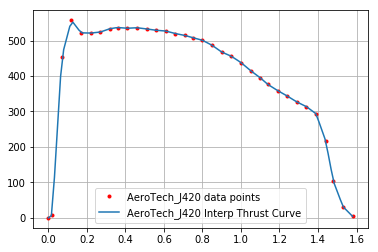

In [285]:
#Rocket Selection
print(color.UNDERLINE, 'ROCKET SELECTED:', color.END)
RocketSelected = Subscale2k18prediction
RocketSelected.printspecs()

print('\n')

#Parachute Selection
drogueChuteSelected = FruityChute15
mainChuteSelected = FruityChute60Iris

print(color.UNDERLINE, 'PARACHUTES SELECTED:', color.END)

print( color.BOLD ,' DROGUE:',color.END)
drogueChuteSelected.printspecs()

print('\n ', color.BOLD, 'MAIN:', color.END)
mainChuteSelected.printspecs()

print('\n')

#Motor Selection
print(color.UNDERLINE, 'MOTOR SELECTED:', color.END)
motorSelected = J420

motorSelected.printspecs()
motorSelected.plotThrustCurve()



In [296]:
#Initial Conditions

h = 0 #initial height
v0 = 0 #initial velocity
m0 = RocketSelected.dryMass + motorSelected.wetMass
mMECO = RocketSelected.dryMass + motorSelected.dryMass
g0 = 9.8 #m/s**2

windSpeedmph = 0#mph
windSpeedms = windSpeedmph*0.44704 #m/s

launchRailLengthft = 8 #ft
launchRailLengthm = launchRailLengthft*0.3048 #m

mainChuteReleaseAlt = 800 #ft
launchRailLengthm = mainChuteReleaseAlt*0.3048 #m

#Static Stability Marigin for Selected Rocket and Motor

###USER INPUT REQUIRED###
motorLength = 18 #in (This will vary with motor selection and not included in the thrust curve txt data....)

CG0 = (RocketSelected.dryMass*RocketSelected.dryCG + (motorLength/2)*motorSelected.wetMass)/(RocketSelected.dryMass + motorSelected.wetMass)
CP = RocketSelected.CP
StaticStabilityMariginSelected = (CG0 - CP)/RocketSelected.diameter

print(color.BOLD, "SELECTED CONFIGURATION", color.END)
print("Gross Lift Off Weight:",round(m0*(10**-3),2),'kg')
print("CP:",round(CP,2),'in')
print("CG:",round(CG,2),'in')
print("Static Stability Marigin:", round(StaticStabilityMariginSelected,2))
thrustToWeightRatio = max(motorSelected.thrustpoints) / (m0*(10**-3)*9.8)
print("Thrust To Weight Ratio:", round(thrustToWeightRatio,2))

 SELECTED CONFIGURATION 
Gross Lift Off Weight: 5.28 kg
CP: 31.7 in
CG: 38.31 in
Static Stability Marigin: 2.29
Thrust To Weight Ratio: 10.76


In [304]:
#Thrust Equation
#F = g0 * ISP * (dm/dt)
#F(t)/(g0 * ISP) = dm/dt
#Euler
#mi = m(i-1) + F(t)/(g0*ISP) * delta t

tmax = 5
steps = 1000
times = linspace(0,tmax,steps)
stepsize = tmax/steps
masses = [m0]
i = 0

def dm(tdm):
    DM = -(float(motorSelected.ThrustCurve(tdm)))/(g0*motorSelected.ISP)
    return DM


while i < len(times)-1:
    timestep = times[i+1] - times[i]
    mi = masses[i] + timestep * 10e3 * dm(times[i])
    masses.append(mi)
    i = i+1



In [305]:
vdm = vectorize(dm)

In [308]:
timestep

0.005005005005005003

In [310]:
times[1]

0.005005005005005005

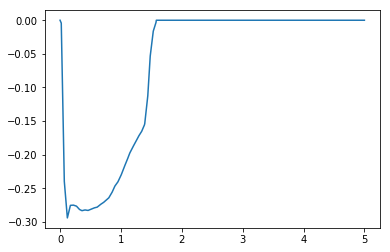

In [306]:
plt.plot(times,vdm(times))

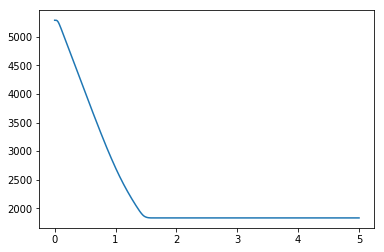

In [307]:
plt.plot(times,masses)

In [255]:
RocketSelected.dryMass

4634.75

In [256]:
motorSelected.propMass

345

In [215]:
motorSelected.totalI/(motorSelected.propMass * (10**(-3)) * 9.8)

177.26199407208188

In [295]:
motorSelected.ISP

193.1898833945008

In [294]:
(motorSelected.propMass * (1e-3))

0.34500000000000003

In [213]:
(int(motorSelected.ThrustCurve(0.125)))/(g0*motorSelected.ISP)

0.31833429226586096

In [193]:
motorSelected.propMass * 10e-4

0.376